In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
#sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
#sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))

In [2]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *
from shared.gem.gem_instance import GEMInstance
from shared.gem.gem_quantum_instance import GEMQuantumInstance
from matplotlib import pyplot as plt
%matplotlib inline

graph_05_06_02


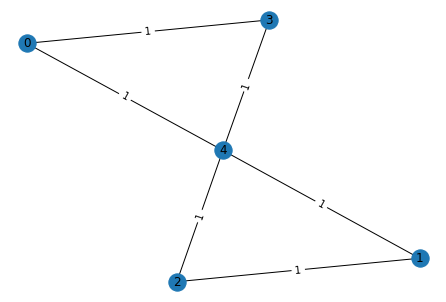

In [3]:
graph = generate_butterfly_graph(with_weights=False)
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
print(graph.name)
max_cut.draw()

In [4]:
step_size = 0.1
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)

In [5]:
a_gamma, b_beta = np.meshgrid(a_gamma, b_beta)
len(a_gamma)

32

In [6]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i,j,w in graph.edges.data('weight'):
        if x[i] != x[j]:
            obj -= w
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [7]:
quantum_instance = GEMQuantumInstance(
                    #backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                    backend=provider.get_backend('ibmq_sydney'),
                    shots=SHOTS)




qaoa = QAOA(
            optimizer=COBYLA(maxiter=0),
            quantum_instance=quantum_instance,
            reps=1
            )

op, offset = max_cut_qubo.to_ising()

In [8]:
def create_cirucit(gamma,beta):
    circuits = qaoa.construct_circuit([gamma,beta], operator=op)
    circuit = circuits[0]
    circuit.measure_all()
    return circuit

In [9]:
gem_instance = GEMInstance()

In [10]:
first_circuit = create_cirucit(0.25,0.25)

In [11]:
mg = gem_instance.get_gem_matrix(first_circuit, quantum_instance)

In [12]:
quantum_instance.MG = mg

In [13]:
landscape = np.zeros(a_gamma.shape)

for i in range(0, len(landscape)):
    circuits = []
    for j in range(0, len(landscape)):
        # create circuits for entire row 
        circuit = create_cirucit(a_gamma[i][j], b_beta[i][j])
        circuits.append(circuit)
    
    # create one job with circuits 
    job_name = f"{graph.name}_gem_row_{i}"
    job = quantum_instance.execute(circuits)
    #job.update_name(job_name)
    print(job_name)
    #print(job)
    
    # add results to landscape 
    j = 0
    for count in job.get_counts():
        mean = compute_expectation(count, graph)
        landscape[i,j] = mean
        j += 1

graph_05_06_02_gem_row_0
graph_05_06_02_gem_row_1
graph_05_06_02_gem_row_2
graph_05_06_02_gem_row_3
graph_05_06_02_gem_row_4
graph_05_06_02_gem_row_5
graph_05_06_02_gem_row_6
graph_05_06_02_gem_row_7
graph_05_06_02_gem_row_8
graph_05_06_02_gem_row_9
graph_05_06_02_gem_row_10
graph_05_06_02_gem_row_11
graph_05_06_02_gem_row_12
graph_05_06_02_gem_row_13
graph_05_06_02_gem_row_14
graph_05_06_02_gem_row_15
graph_05_06_02_gem_row_16
graph_05_06_02_gem_row_17
graph_05_06_02_gem_row_18
graph_05_06_02_gem_row_19
graph_05_06_02_gem_row_20
graph_05_06_02_gem_row_21
graph_05_06_02_gem_row_22
graph_05_06_02_gem_row_23
graph_05_06_02_gem_row_24
graph_05_06_02_gem_row_25
graph_05_06_02_gem_row_26
graph_05_06_02_gem_row_27
graph_05_06_02_gem_row_28
graph_05_06_02_gem_row_29
graph_05_06_02_gem_row_30
graph_05_06_02_gem_row_31


[[-2.87016788 -2.95727718 -2.99752166 ... -2.94162684 -2.98020361
  -2.93865364]
 [-2.9668446  -2.97342097 -2.88898864 ... -3.03530677 -3.01400987
  -2.98448851]
 [-3.02259891 -2.91090646 -2.83209948 ... -3.14918043 -3.08015372
  -2.98057151]
 ...
 [-3.01240153 -3.12021849 -3.21318776 ... -2.57197973 -2.71074695
  -2.8321146 ]
 [-3.10368657 -3.13767222 -3.16926446 ... -2.72155007 -2.79730788
  -2.88025995]
 [-3.15495986 -3.13074437 -3.10123802 ... -2.86709164 -2.91316922
  -2.89771767]]


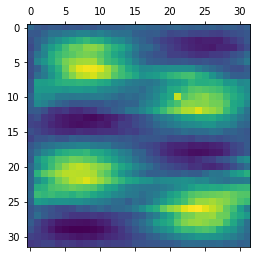

In [14]:
print(landscape)
plt.matshow(landscape)
plt.show()

In [15]:
# Mean of landscape
np.mean(landscape)

-2.730098369079056

In [16]:
# Minimium 
np.min(landscape)

-3.4352927477298847

In [17]:
# Display Coordinates of Minimum 
np.unravel_index(np.argmin(landscape), landscape.shape)

(29, 7)

In [18]:
# Gamma and beta value of Minimium
gamma, beta = np.unravel_index(np.argmin(landscape), landscape.shape)
opt_gamma = gamma * step_size
opt_beta = beta * step_size
print(f"Opt.Gamma: {opt_gamma}, Opt.Beta: {opt_beta}")

Opt.Gamma: 2.9000000000000004, Opt.Beta: 0.7000000000000001


In [19]:
# Save result matrix 
with open('landscape_sydney_butterfly_no_weights_gem_results_2.npy', 'wb') as f:
    np.save(f, landscape)

In [20]:
import plotly.graph_objects as go

In [ ]:
# Plot landscape in 3D 
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)
fig = go.Figure(data=go.Surface(z=landscape, x=a_gamma, y=b_beta))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))


fig.update_layout(title="QAOA with General Error Mitigation - MaxCut-Landscape", scene=dict(
    xaxis_title="γ",
    yaxis_title="β",
    zaxis_title="F(γ,β)"
))

In [ ]:
# Plot Heatmap 
fig = go.Figure(data=go.Heatmap(z=landscape, x=b_beta, y=a_gamma, type = 'heatmap', colorscale = 'viridis'))

# Update Layout
fig.update_layout(title="F(γ,β)", width=700, height=700, yaxis_title="β", xaxis_title="γ")

# Display Global Minimium 
fig.add_trace(
    go.Scatter(mode="markers", x=[opt_beta], y=[opt_gamma], marker_symbol=[204], text = [landscape[gamma,beta]],
                   marker_color="red",  hovertemplate="x: %{x}<br>y: %{y}<br> z: %{text:.2f}<extra></extra>", 
                   marker_line_width=1, marker_size=16))

In [ ]:
# Display Optimizer Results

# Display path 
#fig.add_trace(
#    go.Scatter(mode="lines", x=gammas, y=betas, marker_symbol=[200],
#                   marker_color="white", marker_line_width=1, marker_size=8)
#)

# Display start point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[0]], y=[betas[0]], marker_symbol=[204],
#                   marker_color="gray", 
#                   marker_line_width=1, marker_size=16))

# Display end point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[-1]], y=[betas[-1]], marker_symbol=[204],
#                   marker_color="green", 
#                   marker_line_width=1, marker_size=16))



In [ ]:
# Plot Optimizer History
#fig = go.Figure(data=go.Scatter(x=counts, y=values))
#fig.update_layout(xaxis_title="Evaluation Counts", yaxis_title="Evaluated Mean", title="Optimizer")
#fig.show()